## Going to start off by testing Facenet's embeddings

In [1]:
import ipynb.fs #Boilerplate for import ipynb.fs #Boilerplate for ipynb botebooks as modules

import tensorflow as tf
import numpy as np
import sklearn
from utils import facenet
import os
import sys
import math
import imageio

/home/prudhvi/.conda/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/prudhvi/.conda/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/prudhvi/.conda/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/prudhvi/.conda/envs/tensorflow/lib/python3.4/importlib/_bootstrap.py:321: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
# Choose your seed
seed = 1
np.random.seed(seed=seed)
#Obtain dataset
dataset_path = "~/Desktop/Datasets/lfw/lfw_mtcnnpy_160"
dataset = facenet.get_dataset(dataset_path)

## Note:  
We first need to crop and align the images in a dataset to only show the face before we can go ahead with feeding it into the NN.
The current dataset has already been preprocessed with the below link.
Here's the link for doing that: https://github.com/davidsandberg/facenet/wiki/Validate-on-lfw

### Results of current model being used
Model directory: /home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759  
Metagraph file: model-20180402-114759.meta  
Checkpoint file: model-20180402-114759.ckpt-275  
Runnning forward pass on LFW images  
........................  
Accuracy: 0.99550+-0.00342  
Validation rate: 0.98600+-0.00975 @ FAR=0.00100  
Area Under Curve (AUC): 1.000  
Equal Error Rate (EER): 0.004  

Model structure:
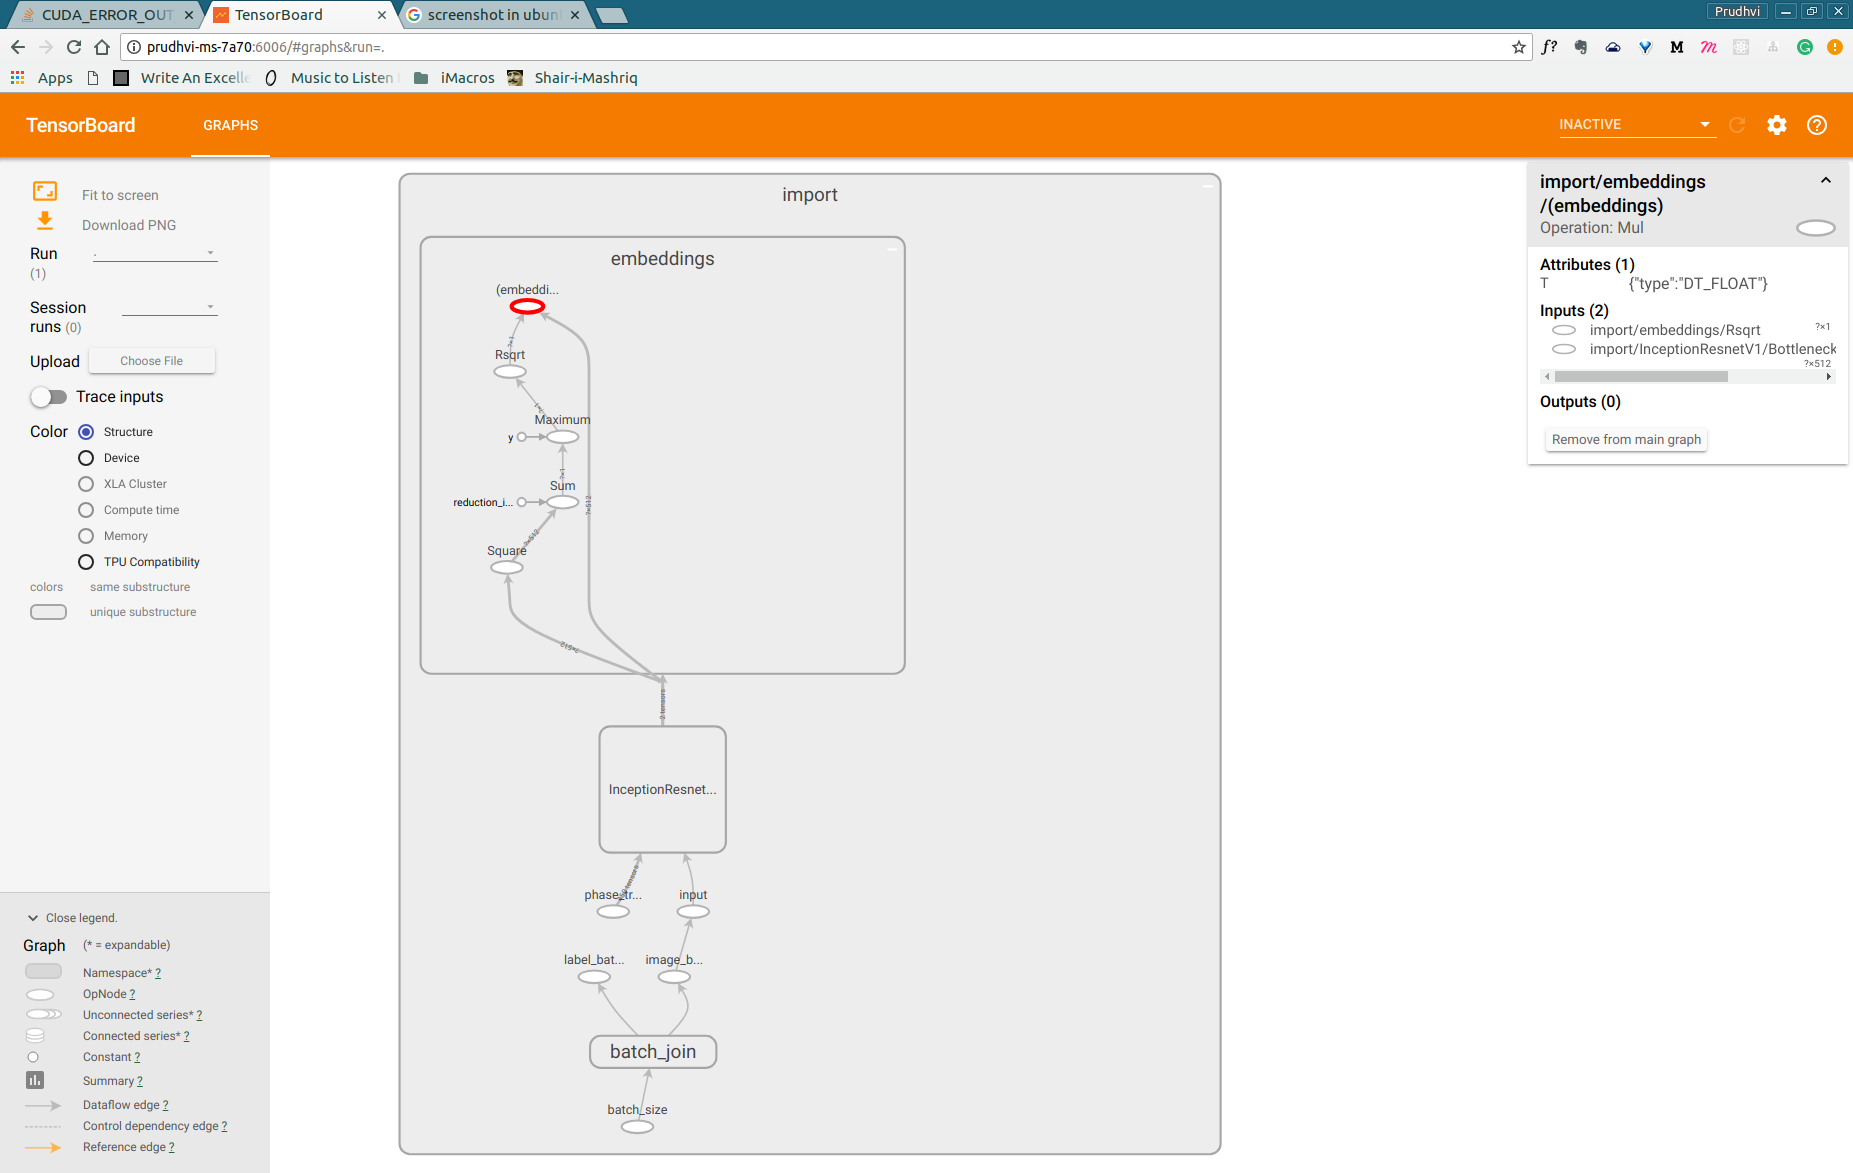

In [6]:
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))
def _bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))
def _float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=value))
def encode_image(image):
    new_g = tf.Graph()
    with new_g.as_default():
        sess = tf.Session()
        encode_image = tf.image.encode_png(tf.cast(tf.constant(image), tf.uint8))
        return sess.run(encode_image)      

In [9]:
def get_face_embeddings(data, image_size = 160, batch_size = 128, save_to_disk = False, save_dir = None, mode = "dataset"):
    
    if save_to_disk:
        print("Saving to disk!")
    
    if mode == 'dataset':
        # Check that there are at least one training image per class
        for cls in data:
            assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')
        
        # Extract and show data stats
        paths, labels = facenet.get_image_paths_and_labels(data)
        print('Number of classes: %d' % len(data))
        print('Number of images: %d' % len(paths))
    elif mode == "paths":
        paths = data
    else:
        print("Error! Wrong mode specified")
        return
    
    with tf.Graph().as_default():
      
        with tf.Session() as sess:
            
            np.random.seed(seed=1)
            
            # Load the model
            print('Loading feature extraction model')
            model_path = '/home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759'
            facenet.load_model(model_path)
            
            # Get input and output tensors
            images_placeholder = tf.get_default_graph().get_tensor_by_name("input:0")
            embeddings = tf.get_default_graph().get_tensor_by_name("embeddings:0")
            phase_train_placeholder = tf.get_default_graph().get_tensor_by_name("phase_train:0")
            embedding_size = embeddings.get_shape()[1]
            print("embedding size", embedding_size)
            
             # Run forward pass to calculate embeddings
            print('Calculating features for images')
            nrof_images = len(paths)
            nrof_batches_per_epoch = int(math.ceil(1.0*nrof_images / batch_size))
            emb_array = np.zeros((nrof_images, embedding_size))
            print("Number of epochs", nrof_batches_per_epoch)
            
            if save_to_disk:
            ## Intialize TFRecord writer
                # open the TFRecords file
                writer = tf.python_io.TFRecordWriter(save_dir)
                
            for i in range(nrof_batches_per_epoch):
                print("\rRunning Epoch #%d%%" % (i), end='')
                start_index = i*batch_size
                end_index = min((i+1)*batch_size, nrof_images)
                paths_batch = paths[start_index:end_index]
                images = facenet.load_data(paths_batch, False, False, image_size, False)
                # Whats a phase train placeholder??
                feed_dict = { images_placeholder:images, phase_train_placeholder:False }
                emb_array[start_index:end_index,:] = sess.run(embeddings, feed_dict=feed_dict)
                if save_to_disk:
                    for i in range(images.shape[0]):
                        image = images[i][:][:][:]
                        #Calculate the path of the image relative to its dataset
                        new_path = '{}/{}'.format(paths_batch[i].split('/')[-2], paths_batch[i].split('/')[-1])
                        feature = {
                        "image_name_path": _bytes_feature(tf.compat.as_bytes(new_path)),
                        "embedding": _float_feature(emb_array[start_index+i].tolist())
                            }
                        # Create an example protocol buffer
                        example = tf.train.Example(features=tf.train.Features(feature=feature))
    
                        # Serialize to string and write on the file
                        writer.write(example.SerializeToString())
            writer.close()
            sys.stdout.flush()
            
            return emb_array

<ipython-input-9-b4c96e17386b>:9: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')


In [11]:
face_emb = get_face_embeddings(dataset, batch_size = 1024, save_to_disk = True, save_dir = "tfrecords2")
print(face_emb.shape)

Saving to disk!
Number of classes: 5749
Number of images: 13233
Loading feature extraction model
Model directory: /home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759/model-20180402-114759.ckpt-275
embedding size 512
Calculating features for images
Number of epochs 13
Running Epoch #0%AJ_Cook/AJ_Cook_0001.png
AJ_Lamas/AJ_Lamas_0001.png
Aaron_Eckhart/Aaron_Eckhart_0001.png
Aaron_Guiel/Aaron_Guiel_0001.png
Aaron_Patterson/Aaron_Patterson_0001.png
Aaron_Peirsol/Aaron_Peirsol_0001.png
Aaron_Peirsol/Aaron_Peirsol_0002.png
Aaron_Peirsol/Aaron_Peirsol_0003.png
Aaron_Peirsol/Aaron_Peirsol_0004.png
Aaron_Pena/Aaron_Pena_0001.png
Aaron_Sorkin/Aaron_Sorkin_0001.png
Aaron_Sorkin/Aaron_Sorkin_0002.png
Aaron_Tippin/Aaron_Tippin_0001.png
Abba_Eban/Abba_Eban_0001.png
Abbas_Kiarostami/Abbas_Kiarostami_0001.png
Abd

Ari_Fleischer/Ari_Fleischer_0006.png
Ari_Fleischer/Ari_Fleischer_0011.png
Ari_Fleischer/Ari_Fleischer_0003.png
Ari_Fleischer/Ari_Fleischer_0008.png
Ari_Fleischer/Ari_Fleischer_0013.png
Ari_Fleischer/Ari_Fleischer_0009.png
Ari_Fleischer/Ari_Fleischer_0001.png
Arianna_Huffington/Arianna_Huffington_0002.png
Arianna_Huffington/Arianna_Huffington_0004.png
Arianna_Huffington/Arianna_Huffington_0001.png
Arianna_Huffington/Arianna_Huffington_0003.png
Arie_Haan/Arie_Haan_0001.png
Ariel_Sharon/Ariel_Sharon_0043.png
Ariel_Sharon/Ariel_Sharon_0047.png
Ariel_Sharon/Ariel_Sharon_0066.png
Ariel_Sharon/Ariel_Sharon_0027.png
Ariel_Sharon/Ariel_Sharon_0030.png
Ariel_Sharon/Ariel_Sharon_0010.png
Ariel_Sharon/Ariel_Sharon_0059.png
Ariel_Sharon/Ariel_Sharon_0049.png
Ariel_Sharon/Ariel_Sharon_0053.png
Ariel_Sharon/Ariel_Sharon_0071.png
Ariel_Sharon/Ariel_Sharon_0045.png
Ariel_Sharon/Ariel_Sharon_0075.png
Ariel_Sharon/Ariel_Sharon_0003.png
Ariel_Sharon/Ariel_Sharon_0055.png
Ariel_Sharon/Ariel_Sharon_0072.png

Running Epoch #1%Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0022.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0024.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0015.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0006.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0014.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0012.png
Atal_Bihari_Vajpayee/Atal_Bihari_Vajpayee_0009.png
Ataollah_Mohajerani/Ataollah_Mohajerani_0001.png
Atiabet_Ijan_Amabel/Atiabet_Ijan_Amabel_0001.png
Atom_Egoyan/Atom_Egoyan_0001.png
Atsushi_Sato/Atsushi_Sato_0001.png
Audrey_Lacroix/Audrey_Lacroix_0001.png
Audrey_Sauret/Audrey_Sauret_0001.png
Augustin_Calleri/Augustin_Calleri_0001.png
Augustin_Calleri/Augustin_Calleri_0004.png
Augustin_Calleri/Augustin_Calleri_0003.png
Augustin_Calleri/Augustin_Calleri_0002.png
Augusto_Pinochet/Augusto_Pinochet_0002.png
Augusto_Pinochet/Augusto_Pinochet_0001.png
Augusto_Roa_Bastos/Augusto_Roa_Bastos_0001.png
Augusto_Roa_Bastos/Augusto_Roa_Bastos_0002.png
Aung_San_Suu_Kyi/Aung_San_Suu_Ky

Carol_Burnett/Carol_Burnett_0002.png
Carol_Burnett/Carol_Burnett_0001.png
Carol_Carmody/Carol_Carmody_0001.png
Carol_Moseley_Braun/Carol_Moseley_Braun_0001.png
Carol_Moseley_Braun/Carol_Moseley_Braun_0002.png
Carol_Niedermayer/Carol_Niedermayer_0001.png
Carol_Williams/Carol_Williams_0001.png
Carolina_Barco/Carolina_Barco_0001.png
Carolina_Kluft/Carolina_Kluft_0001.png
Carolina_Kluft/Carolina_Kluft_0003.png
Carolina_Kluft/Carolina_Kluft_0002.png
Carolina_Moraes/Carolina_Moraes_0002.png
Carolina_Moraes/Carolina_Moraes_0001.png
Caroline_Dhavernas/Caroline_Dhavernas_0001.png
Caroline_Kennedy/Caroline_Kennedy_0002.png
Caroline_Kennedy/Caroline_Kennedy_0001.png
Caroline_Kennedy/Caroline_Kennedy_0003.png
Caroline_Link/Caroline_Link_0001.png
Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0001.png
Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0002.png
Carolyn_Dawn_Johnson/Carolyn_Dawn_Johnson_0003.png
Carolyn_Kuhl/Carolyn_Kuhl_0001.png
Carrie-Anne_Moss/Carrie-Anne_Moss_0003.png
Carrie-Anne_Moss/Carrie-A

Running Epoch #2%Christine_Baumgartner/Christine_Baumgartner_0003.png
Christine_Baumgartner/Christine_Baumgartner_0005.png
Christine_Baumgartner/Christine_Baumgartner_0004.png
Christine_Baumgartner/Christine_Baumgartner_0001.png
Christine_Baumgartner/Christine_Baumgartner_0002.png
Christine_Ebersole/Christine_Ebersole_0002.png
Christine_Ebersole/Christine_Ebersole_0001.png
Christine_Gregoire/Christine_Gregoire_0001.png
Christine_Gregoire/Christine_Gregoire_0003.png
Christine_Gregoire/Christine_Gregoire_0002.png
Christine_Gregoire/Christine_Gregoire_0004.png
Christine_Rau/Christine_Rau_0001.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0004.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0003.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0002.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0006.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0001.png
Christine_Todd_Whitman/Christine_Todd_Whitman_0005.png
Christoph_Daum/Christoph_Daum_0001.png
Christopher_Amolsch/Christophe

David_Stern/David_Stern_0001.png
David_Stern/David_Stern_0003.png
David_Stern/David_Stern_0002.png
David_Stern/David_Stern_0004.png
David_Suazo/David_Suazo_0001.png
David_Surrett/David_Surrett_0001.png
David_Tornberg/David_Tornberg_0001.png
David_Trimble/David_Trimble_0005.png
David_Trimble/David_Trimble_0002.png
David_Trimble/David_Trimble_0001.png
David_Trimble/David_Trimble_0004.png
David_Trimble/David_Trimble_0003.png
David_Welch/David_Welch_0001.png
David_Wells/David_Wells_0007.png
David_Wells/David_Wells_0004.png
David_Wells/David_Wells_0003.png
David_Wells/David_Wells_0005.png
David_Wells/David_Wells_0002.png
David_Wells/David_Wells_0001.png
David_Wells/David_Wells_0006.png
David_Westerfield/David_Westerfield_0001.png
David_Wolf/David_Wolf_0002.png
David_Wolf/David_Wolf_0001.png
David_Zeplowitz/David_Zeplowitz_0001.png
Davis_Love_III/Davis_Love_III_0001.png
Dawn_Staley/Dawn_Staley_0001.png
Dawna_LoPiccolo/Dawna_LoPiccolo_0001.png
Dean_Barker/Dean_Barker_0001.png
Dean_Barkley/Dea

Running Epoch #3%Donald_Rumsfeld/Donald_Rumsfeld_0039.png
Donald_Rumsfeld/Donald_Rumsfeld_0014.png
Donald_Rumsfeld/Donald_Rumsfeld_0070.png
Donald_Rumsfeld/Donald_Rumsfeld_0106.png
Donald_Rumsfeld/Donald_Rumsfeld_0121.png
Donald_Rumsfeld/Donald_Rumsfeld_0031.png
Donald_Rumsfeld/Donald_Rumsfeld_0065.png
Donald_Rumsfeld/Donald_Rumsfeld_0107.png
Donald_Rumsfeld/Donald_Rumsfeld_0005.png
Donald_Rumsfeld/Donald_Rumsfeld_0113.png
Donald_Rumsfeld/Donald_Rumsfeld_0054.png
Donald_Rumsfeld/Donald_Rumsfeld_0060.png
Donald_Rumsfeld/Donald_Rumsfeld_0071.png
Donald_Rumsfeld/Donald_Rumsfeld_0095.png
Donald_Rumsfeld/Donald_Rumsfeld_0057.png
Donald_Rumsfeld/Donald_Rumsfeld_0088.png
Donald_Rumsfeld/Donald_Rumsfeld_0016.png
Donald_Rumsfeld/Donald_Rumsfeld_0061.png
Donald_Rumsfeld/Donald_Rumsfeld_0098.png
Donald_Rumsfeld/Donald_Rumsfeld_0045.png
Donald_Rumsfeld/Donald_Rumsfeld_0104.png
Donald_Rumsfeld/Donald_Rumsfeld_0092.png
Donald_Rumsfeld/Donald_Rumsfeld_0084.png
Donald_Rumsfeld/Donald_Rumsfeld_0041.png

George_Brumley/George_Brumley_0001.png
George_Brumley_III/George_Brumley_III_0001.png
George_Clooney/George_Clooney_0001.png
George_Clooney/George_Clooney_0007.png
George_Clooney/George_Clooney_0008.png
George_Clooney/George_Clooney_0006.png
George_Clooney/George_Clooney_0002.png
George_Clooney/George_Clooney_0003.png
George_Clooney/George_Clooney_0004.png
George_Clooney/George_Clooney_0009.png
George_Clooney/George_Clooney_0005.png
George_Foreman/George_Foreman_0001.png
George_Foreman/George_Foreman_0002.png
George_Galloway/George_Galloway_0001.png
George_Galloway/George_Galloway_0004.png
George_Galloway/George_Galloway_0003.png
George_Galloway/George_Galloway_0002.png
George_Gregan/George_Gregan_0001.png
George_HW_Bush/George_HW_Bush_0006.png
George_HW_Bush/George_HW_Bush_0007.png
George_HW_Bush/George_HW_Bush_0009.png
George_HW_Bush/George_HW_Bush_0001.png
George_HW_Bush/George_HW_Bush_0003.png
George_HW_Bush/George_HW_Bush_0005.png
George_HW_Bush/George_HW_Bush_0002.png
George_HW_B

Running Epoch #4%George_W_Bush/George_W_Bush_0270.png
George_W_Bush/George_W_Bush_0226.png
George_W_Bush/George_W_Bush_0243.png
George_W_Bush/George_W_Bush_0093.png
George_W_Bush/George_W_Bush_0139.png
George_W_Bush/George_W_Bush_0061.png
George_W_Bush/George_W_Bush_0108.png
George_W_Bush/George_W_Bush_0481.png
George_W_Bush/George_W_Bush_0131.png
George_W_Bush/George_W_Bush_0395.png
George_W_Bush/George_W_Bush_0508.png
George_W_Bush/George_W_Bush_0518.png
George_W_Bush/George_W_Bush_0130.png
George_W_Bush/George_W_Bush_0250.png
George_W_Bush/George_W_Bush_0129.png
George_W_Bush/George_W_Bush_0383.png
George_W_Bush/George_W_Bush_0424.png
George_W_Bush/George_W_Bush_0445.png
George_W_Bush/George_W_Bush_0008.png
George_W_Bush/George_W_Bush_0410.png
George_W_Bush/George_W_Bush_0107.png
George_W_Bush/George_W_Bush_0435.png
George_W_Bush/George_W_Bush_0058.png
George_W_Bush/George_W_Bush_0098.png
George_W_Bush/George_W_Bush_0248.png
George_W_Bush/George_W_Bush_0431.png
George_W_Bush/George_

Guillermo_Coria/Guillermo_Coria_0004.png
Guillermo_Coria/Guillermo_Coria_0002.png
Guillermo_Coria/Guillermo_Coria_0015.png
Guillermo_Coria/Guillermo_Coria_0014.png
Guillermo_Coria/Guillermo_Coria_0017.png
Guillermo_Coria/Guillermo_Coria_0016.png
Guillermo_Coria/Guillermo_Coria_0019.png
Guillermo_Coria/Guillermo_Coria_0025.png
Guillermo_Coria/Guillermo_Coria_0024.png
Guillermo_Coria/Guillermo_Coria_0008.png
Guillermo_Coria/Guillermo_Coria_0010.png
Guillermo_Coria/Guillermo_Coria_0029.png
Guillermo_Coria/Guillermo_Coria_0013.png
Guillermo_Monroy/Guillermo_Monroy_0001.png
Guillermo_Ortiz/Guillermo_Ortiz_0001.png
Guillermo_Ortiz/Guillermo_Ortiz_0002.png
Guillermo_Ruiz_Polanco/Guillermo_Ruiz_Polanco_0001.png
Gunilla_Backman/Gunilla_Backman_0001.png
Gunter_Pleuger/Gunter_Pleuger_0001.png
Gunter_Pleuger/Gunter_Pleuger_0003.png
Gunter_Pleuger/Gunter_Pleuger_0004.png
Gunter_Pleuger/Gunter_Pleuger_0007.png
Gunter_Pleuger/Gunter_Pleuger_0005.png
Gunter_Pleuger/Gunter_Pleuger_0002.png
Gunter_Pleug

Running Epoch #5%Hector_Babenco/Hector_Babenco_0001.png
Hector_Grullon/Hector_Grullon_0001.png
Hector_Mitelman/Hector_Mitelman_0001.png
Hedayat_Amin_Arsala/Hedayat_Amin_Arsala_0001.png
Hee-Won_Han/Hee-Won_Han_0003.png
Hee-Won_Han/Hee-Won_Han_0002.png
Hee-Won_Han/Hee-Won_Han_0001.png
Heidi_Fleiss/Heidi_Fleiss_0003.png
Heidi_Fleiss/Heidi_Fleiss_0004.png
Heidi_Fleiss/Heidi_Fleiss_0001.png
Heidi_Fleiss/Heidi_Fleiss_0002.png
Heidi_Klum/Heidi_Klum_0001.png
Heidi_Klum/Heidi_Klum_0005.png
Heidi_Klum/Heidi_Klum_0003.png
Heidi_Klum/Heidi_Klum_0004.png
Heidi_Klum/Heidi_Klum_0002.png
Heinrich_Wolfgang/Heinrich_Wolfgang_0001.png
Heinz_Feldmann/Heinz_Feldmann_0003.png
Heinz_Feldmann/Heinz_Feldmann_0001.png
Heinz_Feldmann/Heinz_Feldmann_0002.png
Heizo_Takenaka/Heizo_Takenaka_0006.png
Heizo_Takenaka/Heizo_Takenaka_0005.png
Heizo_Takenaka/Heizo_Takenaka_0009.png
Heizo_Takenaka/Heizo_Takenaka_0002.png
Heizo_Takenaka/Heizo_Takenaka_0003.png
Heizo_Takenaka/Heizo_Takenaka_0004.png
Heizo_Takenaka/Heizo_Take

Jean-David_Levitte/Jean-David_Levitte_0002.png
Jean-David_Levitte/Jean-David_Levitte_0010.png
Jean-David_Levitte/Jean-David_Levitte_0004.png
Jean-David_Levitte/Jean-David_Levitte_0008.png
Jean-David_Levitte/Jean-David_Levitte_0001.png
Jean-Francois_Lemounier/Jean-Francois_Lemounier_0001.png
Jean-Francois_Pontal/Jean-Francois_Pontal_0002.png
Jean-Francois_Pontal/Jean-Francois_Pontal_0003.png
Jean-Francois_Pontal/Jean-Francois_Pontal_0001.png
Jean-Luc_Bideau/Jean-Luc_Bideau_0001.png
Jean-Marc_Olive/Jean-Marc_Olive_0001.png
Jean-Marc_de_La_Sabliere/Jean-Marc_de_La_Sabliere_0002.png
Jean-Marc_de_La_Sabliere/Jean-Marc_de_La_Sabliere_0001.png
Jean-Patrick_Nazon/Jean-Patrick_Nazon_0001.png
Jean-Pierre_Bemba/Jean-Pierre_Bemba_0001.png
Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0003.png
Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0001.png
Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0004.png
Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0006.png
Jean-Pierre_Raffarin/Jean-Pierre_Raffarin_0007.png
Jean-Pie

Jonathan_Edwards/Jonathan_Edwards_0008.png
Jonathan_Edwards/Jonathan_Edwards_0002.png
Jonathan_Fine/Jonathan_Fine_0001.png
Jonathan_Horton/Jonathan_Horton_0001.png
Jonathan_Karsh/Jonathan_Karsh_0001.png
Jonathan_Mostow/Jonathan_Mostow_0002.png
Jonathan_Mostow/Jonathan_Mostow_0001.png
Jonathan_Schroeder/Jonathan_Schroeder_0001.png
Jonathan_Tiomkin/Jonathan_Tiomkin_0001.png
Jonathan_Woodgate/Jonathan_Woodgate_0001.png
Jong_Thae_Hwa/Jong_Thae_Hwa_0001.png
Jong_Thae_Hwa/Jong_Thae_Hwa_0002.png
Jong_Wook_Lee/Jong_Wook_Lee_0001.png
Jong_Wook_Lee/Jong_Wook_Lee_0002.png
Jong_Wook_Lee/Jong_Wook_Lee_0004.png
Jong_Wook_Lee/Jong_Wook_Lee_0003.png
Jorge_Alberto_Galindo/Jorge_Alberto_Galindo_0001.png
Jorge_Arce/Jorge_Arce_0002.png
Jorge_Arce/Jorge_Arce_0001.png
Jorge_Batlle/Jorge_Batlle_0001.png
Jorge_Batlle/Jorge_Batlle_0002.png
Jorge_Batlle/Jorge_Batlle_0003.png
Jorge_Castaneda/Jorge_Castaneda_0002.png
Jorge_Castaneda/Jorge_Castaneda_0001.png
Jorge_Enrique_Jimenez/Jorge_Enrique_Jimenez_0001.png
Jor

Running Epoch #7%Julianne_Moore/Julianne_Moore_0017.png
Julianne_Moore/Julianne_Moore_0007.png
Julianne_Moore/Julianne_Moore_0013.png
Julianne_Moore/Julianne_Moore_0015.png
Julianne_Moore/Julianne_Moore_0004.png
Julianne_Moore/Julianne_Moore_0010.png
Julianne_Moore/Julianne_Moore_0002.png
Julianne_Moore/Julianne_Moore_0003.png
Julianne_Moore/Julianne_Moore_0011.png
Julianne_Moore/Julianne_Moore_0018.png
Julianne_Moore/Julianne_Moore_0014.png
Julianne_Moore/Julianne_Moore_0005.png
Julianne_Moore/Julianne_Moore_0006.png
Julianne_Moore/Julianne_Moore_0008.png
Julianne_Moore/Julianne_Moore_0012.png
Julianne_Moore/Julianne_Moore_0001.png
Julianne_Moore/Julianne_Moore_0019.png
Julie_Andrews/Julie_Andrews_0001.png
Julie_Gerberding/Julie_Gerberding_0012.png
Julie_Gerberding/Julie_Gerberding_0002.png
Julie_Gerberding/Julie_Gerberding_0004.png
Julie_Gerberding/Julie_Gerberding_0006.png
Julie_Gerberding/Julie_Gerberding_0001.png
Julie_Gerberding/Julie_Gerberding_0005.png
Julie_Gerberding/Julie_Ge

Leonid_Kuchma/Leonid_Kuchma_0003.png
Leonid_Kuchma/Leonid_Kuchma_0002.png
Leonid_Kuchma/Leonid_Kuchma_0004.png
Leonid_Kuchma/Leonid_Kuchma_0001.png
Leonid_Kuchma/Leonid_Kuchma_0006.png
Lesia_Burlak/Lesia_Burlak_0001.png
Lesley_Coppin/Lesley_Coppin_0001.png
Lesley_Flood/Lesley_Flood_0001.png
Lesley_McCulloch/Lesley_McCulloch_0003.png
Lesley_McCulloch/Lesley_McCulloch_0001.png
Lesley_McCulloch/Lesley_McCulloch_0002.png
Leslie_Ann_Woodward/Leslie_Ann_Woodward_0001.png
Leslie_Ann_Woodward/Leslie_Ann_Woodward_0002.png
Leslie_Caldwell/Leslie_Caldwell_0001.png
Leslie_Caldwell/Leslie_Caldwell_0002.png
Leslie_Caldwell/Leslie_Caldwell_0003.png
Leslie_Moonves/Leslie_Moonves_0001.png
Leslie_Moonves/Leslie_Moonves_0002.png
Leslie_Wiser_Jr/Leslie_Wiser_Jr_0001.png
Lester_Holt/Lester_Holt_0001.png
Leszek_Miller/Leszek_Miller_0002.png
Leszek_Miller/Leszek_Miller_0003.png
Leszek_Miller/Leszek_Miller_0001.png
Leticia_Dolera/Leticia_Dolera_0001.png
Leticia_Van_de_Putte/Leticia_Van_de_Putte_0001.png
Leuri

Running Epoch #8%Luis_Berrondo/Luis_Berrondo_0001.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0003.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0001.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0002.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0004.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0005.png
Luis_Ernesto_Derbez_Bautista/Luis_Ernesto_Derbez_Bautista_0006.png
Luis_Figo/Luis_Figo_0001.png
Luis_Figo/Luis_Figo_0003.png
Luis_Figo/Luis_Figo_0002.png
Luis_Figo/Luis_Figo_0004.png
Luis_Fonsi/Luis_Fonsi_0001.png
Luis_Gonzalez/Luis_Gonzalez_0001.png
Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0001.png
Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0004.png
Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0005.png
Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0002.png
Luis_Gonzalez_Macchi/Luis_Gonzalez_Macchi_0003.png
Luis_Guzman/Luis_Guzman_0001.png
Luis_Horna/Luis_Horna_0004.png
Luis_Horna/Luis_Horna_0001.png
Luis_Horna

Michael_Leavitt/Michael_Leavitt_0001.png
Michael_Lechner/Michael_Lechner_0001.png
Michael_Linscott/Michael_Linscott_0001.png
Michael_Lopez-Alegria/Michael_Lopez-Alegria_0001.png
Michael_McNeely/Michael_McNeely_0001.png
Michael_Michele/Michael_Michele_0001.png
Michael_Milton/Michael_Milton_0001.png
Michael_Moore/Michael_Moore_0003.png
Michael_Moore/Michael_Moore_0001.png
Michael_Moore/Michael_Moore_0002.png
Michael_Munoz/Michael_Munoz_0001.png
Michael_Olowokandi/Michael_Olowokandi_0001.png
Michael_Patrick_King/Michael_Patrick_King_0001.png
Michael_Patrick_King/Michael_Patrick_King_0002.png
Michael_Peat/Michael_Peat_0001.png
Michael_Pfleger/Michael_Pfleger_0001.png
Michael_Phelps/Michael_Phelps_0001.png
Michael_Phelps/Michael_Phelps_0005.png
Michael_Phelps/Michael_Phelps_0003.png
Michael_Phelps/Michael_Phelps_0004.png
Michael_Phelps/Michael_Phelps_0002.png
Michael_Piuze/Michael_Piuze_0001.png
Michael_Powell/Michael_Powell_0002.png
Michael_Powell/Michael_Powell_0003.png
Michael_Powell/Mic

Running Epoch #9%Minnie_Driver/Minnie_Driver_0002.png
Minnie_Mendoza/Minnie_Mendoza_0001.png
Mira_Sorvino/Mira_Sorvino_0001.png
Miranda_Gaddis/Miranda_Gaddis_0001.png
Miranda_Otto/Miranda_Otto_0001.png
Mireille_Jospin-Dandieu/Mireille_Jospin-Dandieu_0001.png
Mirela_Manjani/Mirela_Manjani_0001.png
Mireya_Elisa_Moscoso_Rodriguez/Mireya_Elisa_Moscoso_Rodriguez_0001.png
Mireya_Moscoso/Mireya_Moscoso_0002.png
Mireya_Moscoso/Mireya_Moscoso_0001.png
Mireya_Moscoso/Mireya_Moscoso_0003.png
Mireya_Moscoso/Mireya_Moscoso_0005.png
Mireya_Moscoso/Mireya_Moscoso_0004.png
Miroljub/Miroljub_0001.png
Miroljub/Miroljub_0002.png
Missy_Crider/Missy_Crider_0001.png
Misty_Dawn_Clymer/Misty_Dawn_Clymer_0001.png
Mitar_Rasevic/Mitar_Rasevic_0001.png
Mitch_Kupchak/Mitch_Kupchak_0001.png
Mitchell_Crooks/Mitchell_Crooks_0001.png
Mitchell_Daniels/Mitchell_Daniels_0004.png
Mitchell_Daniels/Mitchell_Daniels_0003.png
Mitchell_Daniels/Mitchell_Daniels_0001.png
Mitchell_Daniels/Mitchell_Daniels_0002.png
Mitchell_Garabe

Paul_Tagliabue/Paul_Tagliabue_0003.png
Paul_Tagliabue/Paul_Tagliabue_0004.png
Paul_Tagliabue/Paul_Tagliabue_0002.png
Paul_Tagliabue/Paul_Tagliabue_0001.png
Paul_Tracy/Paul_Tracy_0001.png
Paul_Vathis/Paul_Vathis_0001.png
Paul_Walker/Paul_Walker_0001.png
Paul_Wals/Paul_Wals_0001.png
Paul_Wellstone/Paul_Wellstone_0002.png
Paul_Wellstone/Paul_Wellstone_0001.png
Paul_Wellstone/Paul_Wellstone_0003.png
Paul_William_Hurley/Paul_William_Hurley_0001.png
Paul_William_Hurley/Paul_William_Hurley_0002.png
Paul_Wilson/Paul_Wilson_0001.png
Paul_Wolfowitz/Paul_Wolfowitz_0003.png
Paul_Wolfowitz/Paul_Wolfowitz_0002.png
Paul_Wolfowitz/Paul_Wolfowitz_0005.png
Paul_Wolfowitz/Paul_Wolfowitz_0006.png
Paul_Wolfowitz/Paul_Wolfowitz_0009.png
Paul_Wolfowitz/Paul_Wolfowitz_0010.png
Paul_Wolfowitz/Paul_Wolfowitz_0004.png
Paul_Wolfowitz/Paul_Wolfowitz_0007.png
Paul_Wolfowitz/Paul_Wolfowitz_0008.png
Paul_Wolfowitz/Paul_Wolfowitz_0001.png
Paul_Wollnough/Paul_Wollnough_0001.png
Paula_Abdul/Paula_Abdul_0001.png
Paula_Do

Running Epoch #10%Pierre_Pettigrew/Pierre_Pettigrew_0003.png
Pierre_Png/Pierre_Png_0001.png
Pierre_Van_Hooijdonk/Pierre_Van_Hooijdonk_0001.png
Piers_Sellers/Piers_Sellers_0001.png
Pieter_Bouw/Pieter_Bouw_0001.png
Pilar_Montenegro/Pilar_Montenegro_0001.png
Pinar_del_Rio/Pinar_del_Rio_0001.png
Pio_Laghi/Pio_Laghi_0001.png
Piotr_Anderszewski/Piotr_Anderszewski_0001.png
Placido_Domingo/Placido_Domingo_0003.png
Placido_Domingo/Placido_Domingo_0001.png
Placido_Domingo/Placido_Domingo_0002.png
Platon_Lebedev/Platon_Lebedev_0001.png
Poala_Suarez/Poala_Suarez_0001.png
Polona_Bas/Polona_Bas_0001.png
Porter_Goss/Porter_Goss_0001.png
Portia_de_Rossi/Portia_de_Rossi_0001.png
Prakash_Hinduja/Prakash_Hinduja_0001.png
Prem_Kumar_Nair/Prem_Kumar_Nair_0001.png
Prince_Charles/Prince_Charles_0004.png
Prince_Charles/Prince_Charles_0002.png
Prince_Charles/Prince_Charles_0003.png
Prince_Charles/Prince_Charles_0001.png
Prince_Charles/Prince_Charles_0005.png
Prince_Claus/Prince_Claus_0001.png
Prince_Claus/Prin

Ronald_Kadish/Ronald_Kadish_0001.png
Ronald_Kessler/Ronald_Kessler_0001.png
Ronald_Perelman/Ronald_Perelman_0001.png
Ronald_Post/Ronald_Post_0001.png
Ronald_Reagan/Ronald_Reagan_0001.png
Ronald_Reagan/Ronald_Reagan_0003.png
Ronald_Reagan/Ronald_Reagan_0002.png
Ronald_White/Ronald_White_0001.png
Ronald_Young_Jr/Ronald_Young_Jr_0001.png
Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0002.png
Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0001.png
Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0003.png
Ronaldo_Luis_Nazario_de_Lima/Ronaldo_Luis_Nazario_de_Lima_0004.png
Ronde_Barber/Ronde_Barber_0001.png
Ronnie_Jagday/Ronnie_Jagday_0001.png
Ronnie_Musgrove/Ronnie_Musgrove_0001.png
Rosa_Haywa_de_Condori/Rosa_Haywa_de_Condori_0001.png
Rosalie_Perkov/Rosalie_Perkov_0001.png
Rosalyn_Carter/Rosalyn_Carter_0001.png
Rosario_Dawson/Rosario_Dawson_0001.png
Rose_Linkins/Rose_Linkins_0001.png
Rose_Marie/Rose_Marie_0001.png
Roseanne_Barr/Roseanne_Barr_0002.png
Roseanne_

Thabo_Mbeki/Thabo_Mbeki_0002.png
Thabo_Mbeki/Thabo_Mbeki_0005.png
Thabo_Mbeki/Thabo_Mbeki_0001.png
Thabo_Mbeki/Thabo_Mbeki_0003.png
Thad_Matta/Thad_Matta_0001.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0005.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0006.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0003.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0004.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0001.png
Thaksin_Shinawatra/Thaksin_Shinawatra_0002.png
Thalia/Thalia_0001.png
Thanongsak_Tuvinan/Thanongsak_Tuvinan_0001.png
Theo_Angelopoulos/Theo_Angelopoulos_0001.png
Theo_Epstein/Theo_Epstein_0001.png
Theo_Epstein/Theo_Epstein_0002.png
Theodore_Tweed_Roosevelt/Theodore_Tweed_Roosevelt_0003.png
Theodore_Tweed_Roosevelt/Theodore_Tweed_Roosevelt_0001.png
Theodore_Tweed_Roosevelt/Theodore_Tweed_Roosevelt_0002.png
Theresa_Gattung/Theresa_Gattung_0001.png
Theresa_May/Theresa_May_0001.png
Theresa_May/Theresa_May_0002.png
Theresa_May/Theresa_May_0003.png
Thierry_Falise/Thierry_Falise_0001.png
Thierry_Falise

Running Epoch #12%Tom_Harkin/Tom_Harkin_0001.png
Tom_Harkin/Tom_Harkin_0004.png
Tom_Harkin/Tom_Harkin_0002.png
Tom_Harkin/Tom_Harkin_0003.png
Tom_Izzo/Tom_Izzo_0001.png
Tom_Jones/Tom_Jones_0001.png
Tom_Jones/Tom_Jones_0002.png
Tom_Kelly/Tom_Kelly_0001.png
Tom_Koenigs/Tom_Koenigs_0001.png
Tom_Lantos/Tom_Lantos_0001.png
Tom_McClintock/Tom_McClintock_0001.png
Tom_Miller/Tom_Miller_0001.png
Tom_Moss/Tom_Moss_0001.png
Tom_OBrien/Tom_OBrien_0001.png
Tom_Osborne/Tom_Osborne_0001.png
Tom_Poston/Tom_Poston_0001.png
Tom_Reilly/Tom_Reilly_0001.png
Tom_Reilly/Tom_Reilly_0002.png
Tom_Reilly/Tom_Reilly_0003.png
Tom_Ridge/Tom_Ridge_0001.png
Tom_Ridge/Tom_Ridge_0027.png
Tom_Ridge/Tom_Ridge_0030.png
Tom_Ridge/Tom_Ridge_0014.png
Tom_Ridge/Tom_Ridge_0018.png
Tom_Ridge/Tom_Ridge_0023.png
Tom_Ridge/Tom_Ridge_0029.png
Tom_Ridge/Tom_Ridge_0031.png
Tom_Ridge/Tom_Ridge_0015.png
Tom_Ridge/Tom_Ridge_0013.png
Tom_Ridge/Tom_Ridge_0028.png
Tom_Ridge/Tom_Ridge_0002.png
Tom_Ridge/Tom_Ridge_0011.png
Tom_Ridge/Tom_Ridg

Xanana_Gusmao/Xanana_Gusmao_0004.png
Xavier_Malisse/Xavier_Malisse_0002.png
Xavier_Malisse/Xavier_Malisse_0003.png
Xavier_Malisse/Xavier_Malisse_0005.png
Xavier_Malisse/Xavier_Malisse_0001.png
Xavier_Malisse/Xavier_Malisse_0004.png
Xiang_Huaicheng/Xiang_Huaicheng_0001.png
Xiang_Liu/Xiang_Liu_0001.png
Xiang_Xu/Xiang_Xu_0001.png
Ximena_Bohorquez/Ximena_Bohorquez_0001.png
Yale_Kamisar/Yale_Kamisar_0001.png
Yana_Klochkova/Yana_Klochkova_0001.png
Yang_Hee_Kim/Yang_Hee_Kim_0001.png
Yang_Jianli/Yang_Jianli_0001.png
Yang_Pao-yu/Yang_Pao-yu_0001.png
Yann_Martel/Yann_Martel_0002.png
Yann_Martel/Yann_Martel_0001.png
Yannos_Papantoniou/Yannos_Papantoniou_0001.png
Yao_Ming/Yao_Ming_0008.png
Yao_Ming/Yao_Ming_0003.png
Yao_Ming/Yao_Ming_0006.png
Yao_Ming/Yao_Ming_0001.png
Yao_Ming/Yao_Ming_0004.png
Yao_Ming/Yao_Ming_0007.png
Yao_Ming/Yao_Ming_0005.png
Yao_Ming/Yao_Ming_0002.png
Yasar_Yakis/Yasar_Yakis_0002.png
Yasar_Yakis/Yasar_Yakis_0003.png
Yasar_Yakis/Yasar_Yakis_0001.png
Yasar_Yakis/Yasar_Yakis_0

## Now we'll validate these face embeddings with a few samples to check for robustness

In [14]:
from scipy.spatial import distance
import matplotlib.pyplot as plt
from imageio import imread


In [15]:
# %matplotlib inline

In [16]:
def calc_dist(emb1, emb2):
    concat = np.concatenate([emb1, emb2])
    mean = np.mean(concat)
    emb1 = emb1 - mean
    emb2 = emb2 - mean
    dot = np.sum(np.multiply(emb1, emb2))
    norm = np.linalg.norm(emb1) * np.linalg.norm(emb2)
    similarity = dot / norm
    dist = np.arccos(similarity) / math.pi
    return dist

In [17]:
def print_face_dist(face_1, face_2, dataset, face_emb):
    print(calc_dist(face_emb[face_1], face_emb[face_2]))
    paths, labels = facenet.get_image_paths_and_labels(dataset)
    plt.subplot(1, 2, 1)
    plt.imshow(imread(paths[face_1]))
    plt.subplot(1, 2, 2)
    plt.imshow(imread(paths[face_2]))

### Lets test on the LFW dataset

0.09480027945198506


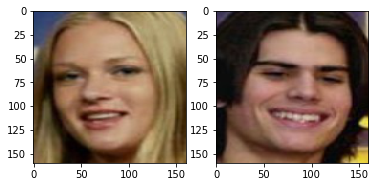

In [19]:
print_face_dist(0, 1, dataset, face_emb)

### Now lets test on the Media LabMembers dataset

In [9]:
#Obtain dataset
dataset_path = "~/Desktop/Datasets/LabMembers/mtcnnpy_160"
dataset = facenet.get_dataset(dataset_path)
face_emb = get_face_embeddings(dataset, image_size = 160, batch_size = 64)

Number of classes: 5
Number of images: 43
Loading feature extraction model
Model directory: /home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759
Metagraph file: model-20180402-114759.meta
Checkpoint file: model-20180402-114759.ckpt-275
INFO:tensorflow:Restoring parameters from /home/prudhvi/Desktop/Models/tf/Facenet/20180402-114759/model-20180402-114759.ckpt-275
embedding size 512
Calculating features for images
Number of epochs 1


0.48491911045506947


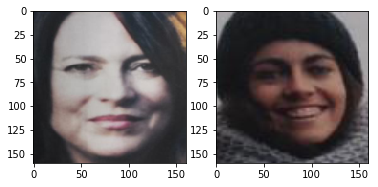

In [95]:
print_face_dist(25, 6, dataset, face_emb)